In [1]:
import numpy as np
import corner
import h5py
import json
import sys
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q
import pycbc
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

import matplotlib.lines as mpllines
from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q
from pycbc.waveform import waveform
from pycbc.types.frequencyseries import FrequencySeries
from pycbc.conversions import mass1_from_mchirp_eta, mass2_from_mchirp_eta, mchirp_from_mass1_mass2, eta_from_mass1_mass2, q_from_mass1_mass2
from plotting_utils import pos_samples, plot_corner_2datasets, plot_corner_3datasets, title_formats



In [2]:
#-- Intrinsic Source frame parameters --

m1_src = 1.387
m2_src = 1.326
s1z = 0.0001294116725339975
s2z = 3.5461352589076355e-05


#-- fixed extrinsic parameters --

iota, pol = np.pi/6, 0

## For observing posteriors of a particular simulation (Out of 400 total Simulations)

In [3]:
#-- combination considered --

combination = 'H1V1K1'

In [4]:
count = 0

ra, dec, dL, z, tc = np.loadtxt('../injections_Net_SNR_20_to_25_{}.txt'.format(combination))[count, :5]


In [5]:
#-- Detector Frame masses --

m1 = m1_src * (1+z)
m2 = m2_src * (1+z)


In [6]:
#-- Derived Params from injections--

mchirp_center = mchirp_from_mass1_mass2(m1, m2)

eta_center = eta_from_mass1_mass2(m1, m2)

chi_eff_center = pycbc.conversions.chi_eff(m1, m2, s1z, s2z)

mass_ratio_center = q_from_mass1_mass2(m1, m2)


In [7]:
#-- injected truth values --

truths = [mchirp_center, mass_ratio_center, chi_eff_center, ra, dec, iota, dL, z]
truths

[1.2204496428145044,
 1.046003016591252,
 8.349271778023214e-05,
 1.702665616136213,
 0.9849884889312752,
 0.5235987755982988,
 153.43756676767495,
 0.03380310515269087]

In [8]:
#-- reading the samples from posterior file

with h5py.File('../post_samples/post_samples_interp_SNR_20to25_{}.hdf'.format(combination)) as f:
    
    samples = f['injection_{}'.format(count)]
    
    print(samples.keys())
    
    mchirp, q, chi_eff = np.array(samples['Mc']), np.array(samples['mass_ratio']), np.array(samples['chi_eff'])    
    iota, ra, dec = np.array(samples['iota']), np.array(samples['ra']), np.array(samples['dec'])
    z, dL =  np.array(samples['z']), np.array(samples['dL'])
    
samps_rbf =   np.column_stack((mchirp, q, chi_eff, ra, dec, iota, dL, z))

<KeysViewHDF5 ['Mc', 'Vcom', 'chi1z', 'chi2z', 'chi_eff', 'dL', 'dec', 'iota', 'mass_ratio', 'pol', 'ra', 'tc', 'z']>


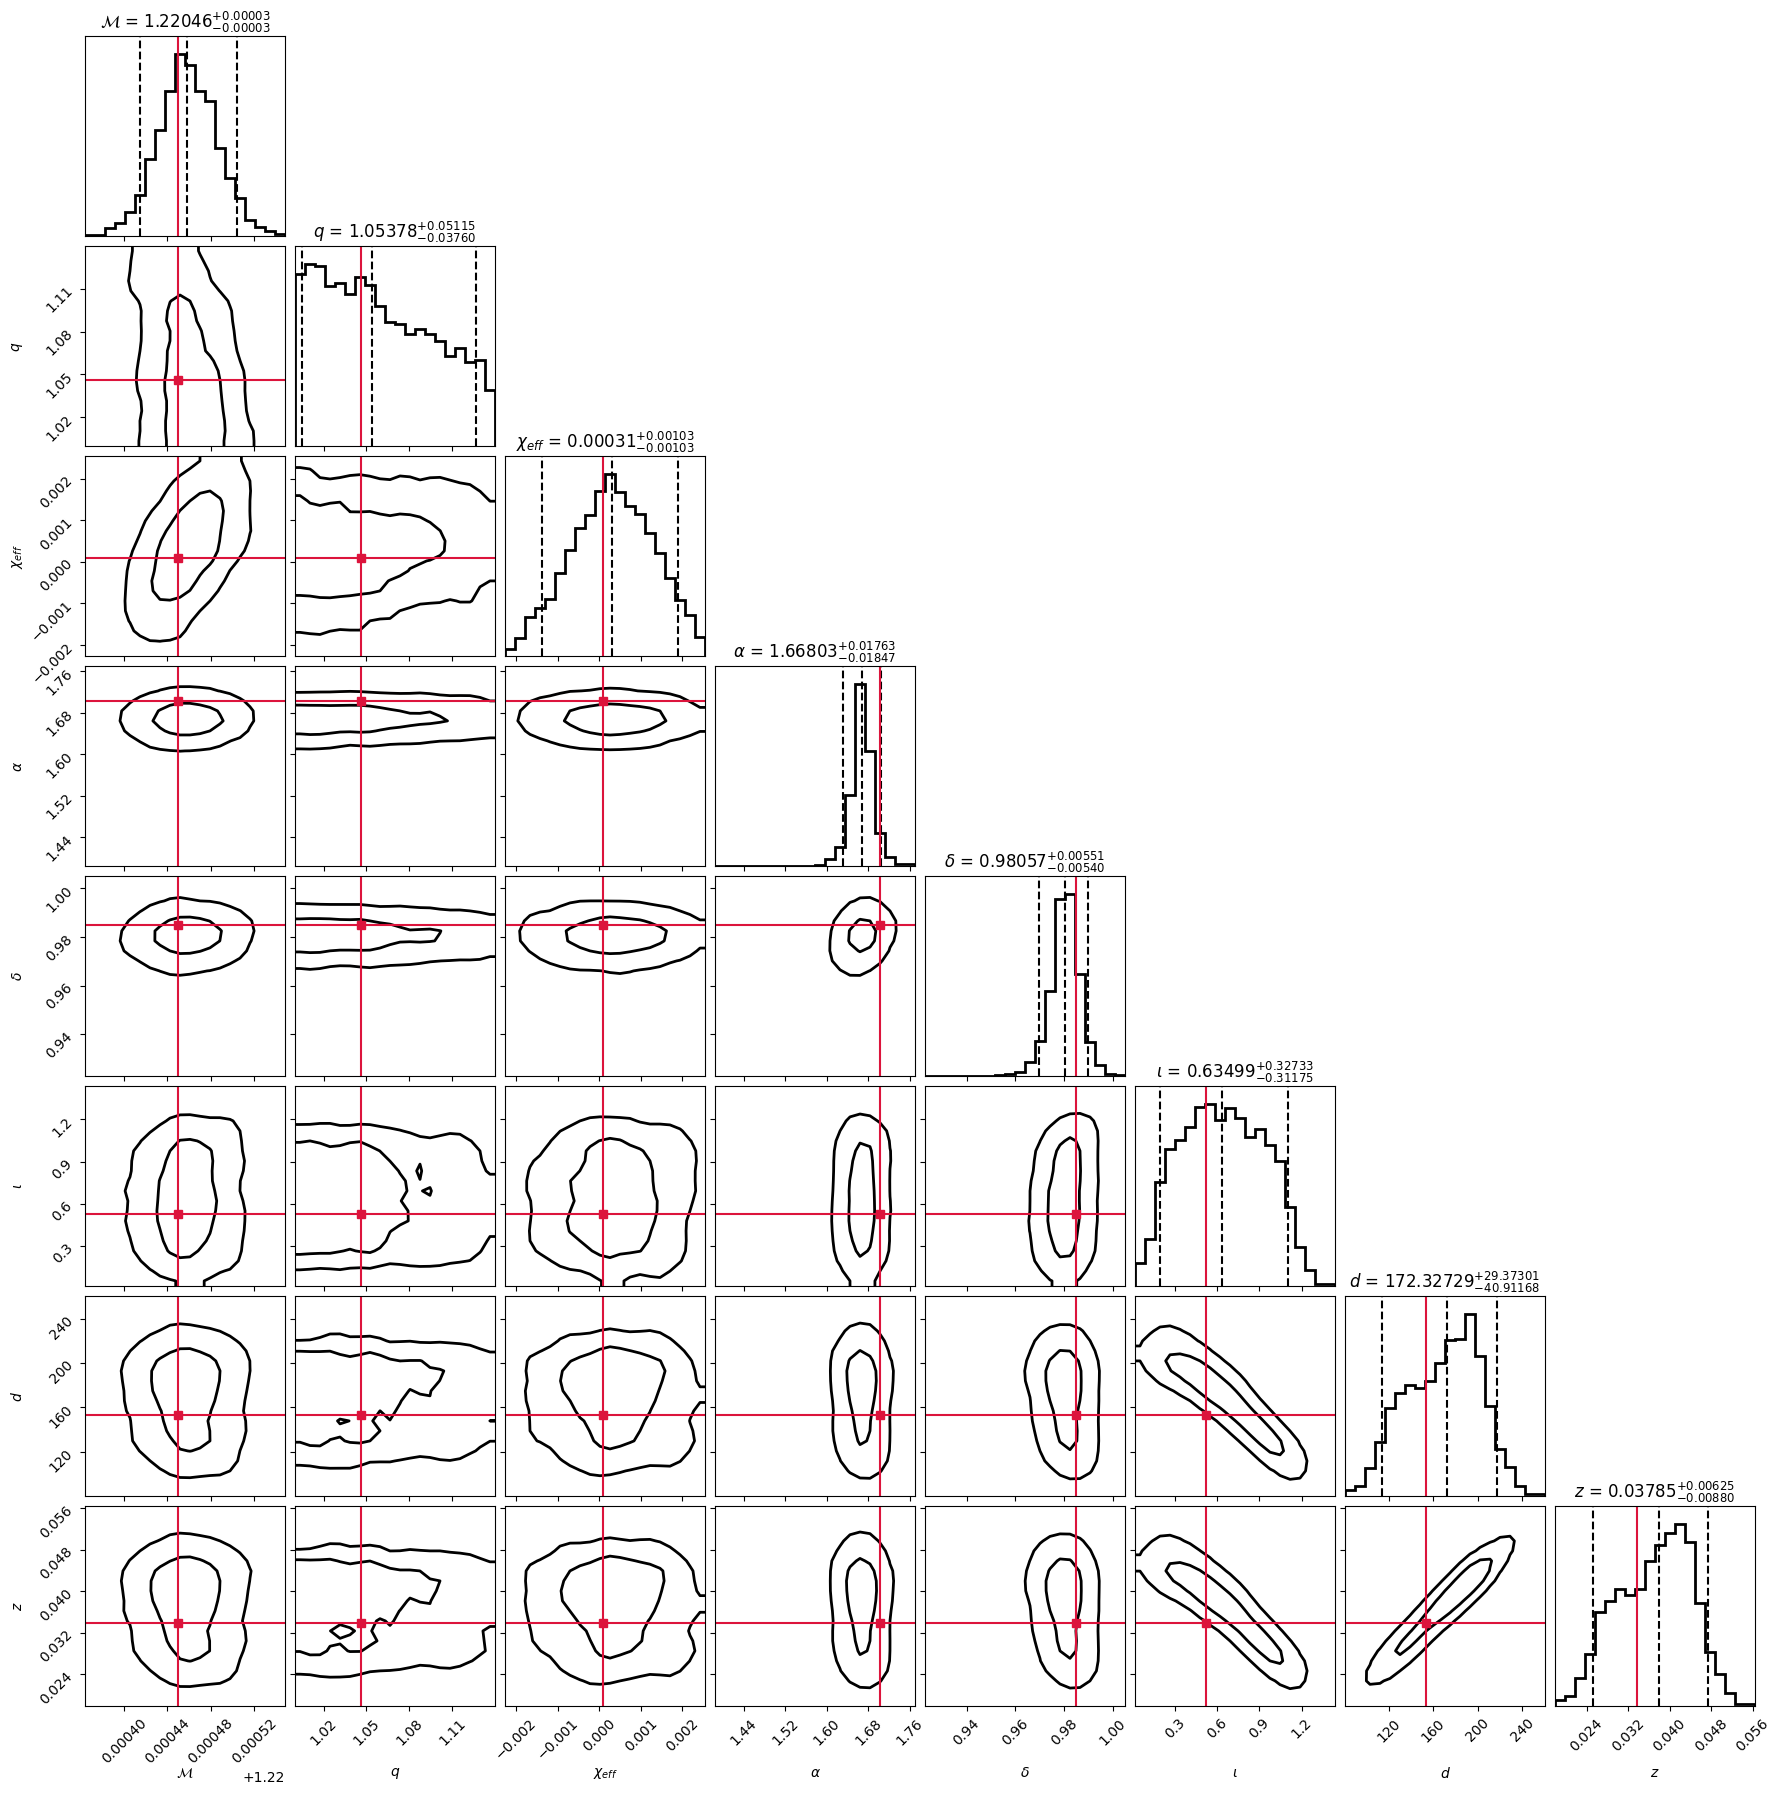

In [9]:
#-- corner plot --

labels = [r'$\mathcal{M}$', r'$q$', r'$\chi_{eff}$', r'$\alpha$', r'$\delta$', r'$\iota$', r'$d$', r'$z$']

corner.corner(samps_rbf, truths=truths, quantiles=[0.05, 0.5, 0.95], labels=labels, hist_kwargs=dict(lw=2), contour_kwargs=dict(linewidths=2), \
             truth_color='crimson', plot_datapoints=False, plot_density=False, show_titles=True, smooth=0.9, levels=[0.5, 0.9], title_fmt='.5f');


## Calculating the Error and relevent Statistics 

In [6]:

def calc_mode(samps, bins):
    
    """Function to calculate the mode
    
    Parameters
    -----------
    samps: samples
    bins: number of bins for np.histogram
    
    Returns
    --------
    map_val: mode/MAP value"""
    
    
    kernel = gaussian_kde(samps)
    count, val = np.histogram(samps, bins)
    val_pdf = kernel.pdf(val)
    map_val = val[np.argmax(val_pdf)]
    
    return map_val


In [13]:
##-- map vs injected value comparison --

#-- loading the injection data from .txt file --

injection_data = np.loadtxt('../injections_Net_SNR_20_to_25_{}.txt'.format(combination))

#-- defining a variable to store the total no. of injections --

total_injections = len(injection_data[:400])   #-- We take only first 400 samples for our analysis

#-- for truth values --

count = 0

truth_vals = np.zeros((total_injections, 8))

for count in range(total_injections):   # this will go from 0 to 399 (total 400)
    
    ra, dec, dL, z = injection_data[count, :4]
    
    m1 = m1_src * (1+z)
    m2 = m2_src * (1+z)
    
    mchirp_true = mchirp_from_mass1_mass2(m1, m2)

    chi_eff_true = pycbc.conversions.chi_eff(m1, m2, s1z, s2z)

    mass_ratio_true = q_from_mass1_mass2(m1, m2)
    
    iota_true = np.pi/6
    
    temp = np.array([mchirp_true, mass_ratio_true, chi_eff_true, ra, dec, iota_true, dL, z])
    
    k = 0
    
    while (k<8):
        
        truth_vals[count,k] = temp[k]
        k += 1
              
    

In [14]:
len(truth_vals)

400

In [125]:
#-- for map values of the posterior samples --

#-- total number of samples whose PE is done from the simulations --

samples_completed = 100

#-- storing containers --
map_vals = np.zeros((samples_completed, 8))

error = np.zeros((samples_completed, 8))


for count in tqdm(range(len(map_vals))):
    
    with h5py.File('../post_samples/post_samples_interp_SNR_20to25_{}.hdf'.format(combination), 'r') as f:

        samples = f['injection_{}'.format(count)]

        mchirp, q, chi_eff = np.array(samples['Mc']), np.array(samples['mass_ratio']), np.array(samples['chi_eff'])    
        iota, ra, dec = np.array(samples['iota']), np.array(samples['ra']), np.array(samples['dec'])
        z, dL =  np.array(samples['z']), np.array(samples['dL'])
        
        samps = np.array([mchirp, q, chi_eff, ra, dec, iota, dL, z])
            
        k=0

        while(k<8):

            map_vals[count, k] = calc_mode(samps[k], 20)
            
            error[count, k] = abs(truth_vals[count, k] - map_vals[count, k])
                                  
            k += 1   
                
            
            

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:24<00:00, 16.28it/s]


The array is stored in the following sequence of parameters:

```temp = np.array([mchirp_true, mass_ratio_true, chi_eff_true, ra, dec, iota_true, dL, z])```

In [102]:
np.argmax(error[:,4])

80

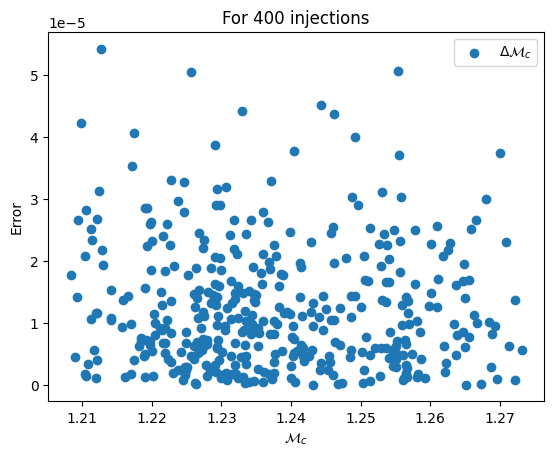

In [126]:
#-- For Chirp Mass --

plt.scatter(truth_vals[:400, 0], error[:, 0]/truth_vals[:400, 0], label=r'$\frac{\Delta\mathcal{M}_c}{\mathcal{M}_c}$')
plt.xlabel(r'$\mathcal{M}_c$')
plt.ylabel('Relative Error')
plt.title('For 400 injections')
plt.legend()
plt.show()

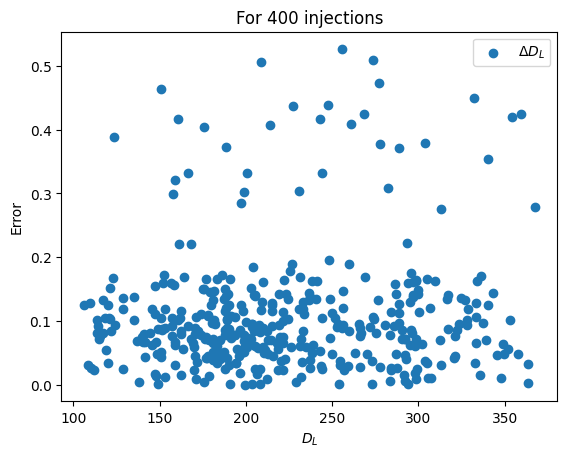

In [139]:
#-- For Luminosity Distance --

plt.scatter(truth_vals[:400, 6 ], error[:, 6]/truth_vals[:400, 6 ], label=r'$\frac{\Delta D_L}{D_L}$')
plt.xlabel(r'$ D_L$')
plt.ylabel('Relative Error')
plt.title('For 400 injections')
plt.legend()
plt.show()

(array([26., 37., 59., 78., 48., 37., 36., 41., 25., 13.]),
 array([106.12417238, 132.24789378, 158.37161519, 184.49533659,
        210.61905799, 236.74277939, 262.86650079, 288.99022219,
        315.11394359, 341.23766499, 367.36138639]),
 <BarContainer object of 10 artists>)

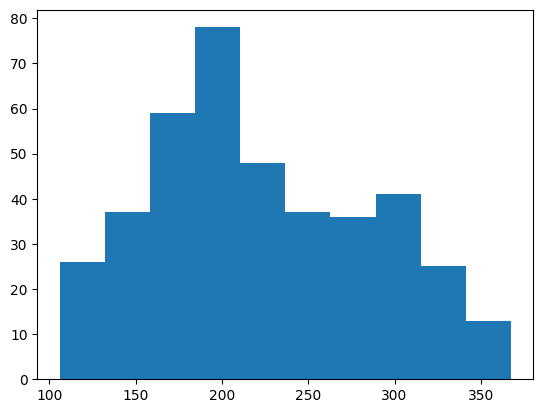

In [140]:
#-- Distance distribution --

plt.hist(truth_vals[:400, 6 ])

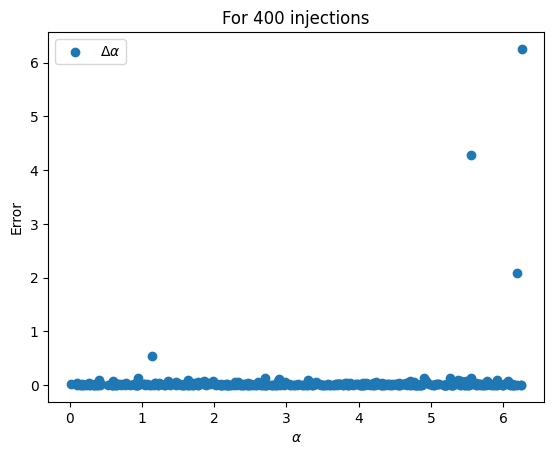

In [128]:
#-- For Right Ascension --

plt.scatter(truth_vals[:400, 3 ], error[:, 3], label=r'$\frac{\Delta \alpha}{\alpha}$')
plt.xlabel(r'$\alpha$')
plt.ylabel('Relative Error')
plt.title('For 400 injections')
plt.legend()
plt.show()

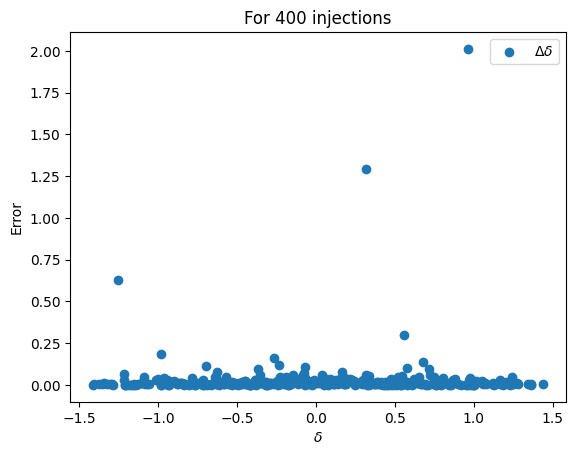

In [129]:
#-- for Declination --

plt.scatter(truth_vals[:400, 4], error[:, 4], label=r'$\frac{\Delta \delta}{\delta}$')
plt.xlabel(r'$\delta$')
plt.ylabel('Relative Error')
plt.title('For 400 injections')
plt.legend()
plt.show()

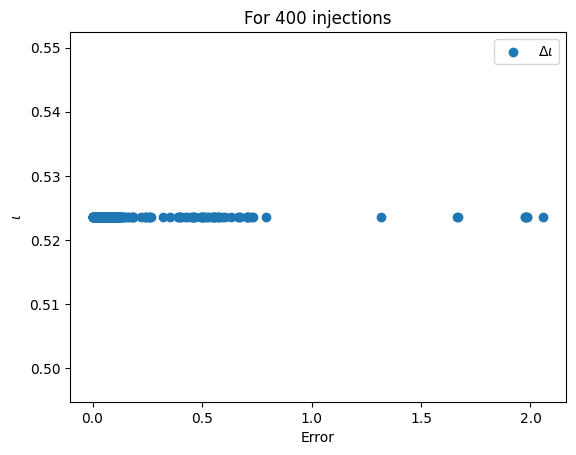

In [131]:
#-- For Inclination (fixed at i= 30 deg)

plt.scatter(error[:, 5], truth_vals[:400, 5 ], label=r'$\frac{\Delta \iota}{\iota}$')
plt.ylabel(r'$ \iota$')
plt.xlabel('Relative Error')
plt.title('For 400 injections')
plt.legend()
plt.show()

In [37]:
mchirp_center - np.median(samps_rbf[:,0])

-2.3107103441777355e-05

In [38]:
mchirp_center, np.median(samps_rbf[:,0])

(1.187760093888219, 1.1877832009916607)

In [39]:
mass_ratio_center,  np.median(samps_rbf[:,1])

(1.0460030165912517, 1.1141615702324241)